# Math Lectures
### Unit 4 Capstone (Thinkful Data Science)
In this note book we will use common techniques in Natural Language Processing to tokenize the closed captioning of 93 lectures aquired as XML files from the internet.
Project Outline:
 - Process the XML into text (removing html tags)
 - Vectorize each sentence using tf idf and Doc2Vec
 - Calculate the cosine similarity of sentences
 - Use KMeans clustering to cluster the sentences
 - Reduce the dimensionality using t-SNE and PCA
 - Visualize the results
 - Examine the text of the cluster assignments
 - Examine frequency of word use and subject professor density of each cluster
 - Use NMF (non-negative matrix factorization) to extract topics
 - Building a supervised model to predict the subject/professor of the sentence.
 - Compare the results of the two classification methods


In [2]:
import os
import time
from collections import Counter, OrderedDict
from itertools import islice
import smart_open

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, ensemble, linear_model, naive_bayes, neighbors, svm
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit


from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')
warnings.filterwarnings("ignore",category=DeprecationWarning)


default_stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
sns.set(style='dark',context='paper',palette='mako')
%matplotlib inline


 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [3]:
glob_time1 = time.time()

### Importing the data
    - The texts consist of the closed captioning for 93 lectures on varying topics in mathematics, computer science, and engineering
    - The XML files were accessed through the console in a web browser and saved as XML 

In [4]:
#set path to XML files
path = '/root/Desktop/gits/unit-4-NLP-capstone/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([re.sub('.xml','',os.fsdecode(file)) for file in os.listdir(folder)])
#filenames = [ re.sub('.xml','',i) for i in filenames ]

#Use ElementTree trace xml tree and extract text from xml files, removing tags
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}.xml'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)

In [5]:
#check some text from a random lecture
lecture_texts[47][30:35]

['the most common change of\nvariables is the one simple one',
 'called scaling.\nSo, again, the kind of equation',
 "I'm talking about is a general\nfirst-order equation.",
 'And, scaling simply means to\nchange the coordinates,',
 'in effect, or axes,\nto change the coordinates on']

In [6]:
#create a DataFrame for records
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = [ ' '.join(i) for i in lecture_texts ] #unpack list of lists as string
print(type(raw_data.raw_text[0]))
raw_data.head(1)

<class 'str'>


filename                                           raw_text
0  aurouxmcalc1  So let's start right away with\nstuff that we ...

### Cleaning the text

Now we will clean the text removing '\n', the intros (MIT has a long intro), the professor names and other undesirable punctuation etc. Also, we want to replace contractions with thier full counterparts.

In [7]:
#Function to remove identified words through visual inspection
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. ",'',text)
    text = re.sub('Your support will help MIT OpenCourseWare continue to',' ',text)
    text = re.sub(' offer high quality educational resources for free.',' ',text)
    text = re.sub('To make a donation or ',' ',text)
    text = re.sub('view additional materials from hundreds of MIT',' ',text)   
    text = re.sub(' courses, visit MIT OpenCourseWare at ocw.mit.edu.',' ',text)   
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    text = re.sub('Welcome to 6.851 Advanced Data Structures', 'PROFESSOR',text)
    text = re.sub('PROFESSOR: PROFESSOR', ' ',text)
    text = re.sub('PROFESSOR PROFESSOR', ' ',text)
    return text

#list common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


In [8]:
raw_data.raw_text = [ expand_contractions(i) for i in raw_data.raw_text]
raw_data.raw_text = [ text_cleaner(i) for i in raw_data.raw_text]

In [9]:
#label professors
raw_data['Professor'] = ['Auroux']*4 + ['Demaine']*7 + ['Devadas']*9 + ['Jerison']*9 + ['Leighton']*11 + ['Manning']*3 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*18 + ['Winston']* 8
#label_subjects
raw_data['Subject'] = ['Calculus']*4 + ['Data']*7 + ['Algorithms']*9 + ['Calculus']*9 + ['CS Math']*11 + ['NLP']*3\
+ ['Differential Equations']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 8 +\
['AI']*8
raw_data.head(1)

filename                                           raw_text Professor  \
0  aurouxmcalc1  So let us start right away with stuff that we ...    Auroux   

    Subject  
0  Calculus

### Tokenization with spacy

Here we will parse the text using spacy and append each spacy object (each lecture) to the dataframe.
Then we will create a new data frame with the professor, subject, filename and the spacy doc.
We will use a list comprehension to tokenize each sentences from each lecture and append the list of lists to the dataframe.
Then we will drop the spacy doc, we will -explode- the data frame so that each sentence is an observation, while maintaining tracability to the lecture level.
We will also take the sentence length for further sentence elimination.

In [10]:
#Create Spacy document for each lecture
t1 = time.time()
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]
print('Minutes: {}'.format((time.time()-t1)/60))

Minutes: 3.5200816988945007


In [11]:
#create a new data frame for the professor,subject and the spacy doc
sentences = raw_data[['filename','Professor','Subject','sdoc']].copy()

#create a list of lists of tokens (remove stop words and punct) 
sentences['sents'] = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in sentences.sdoc]

#explode the df to a new df with each sentence on one line
sentences1 = pd.DataFrame({
         col:np.repeat(sentences[col].values, sentences['sents'].str.len())
         for col in sentences.columns.difference(['sents'])
         }).assign(**{'sents':np.concatenate(sentences['sents'].values)})[sentences.columns.tolist()]

#get sentence lengths
sentences1['s_len'] = [len(sent) for sent in sentences1.sents]

In [12]:
#check to make sure distribution of attributes to sentences
sentences1.sample(5,random_state=43)

filename Professor     Subject  \
59242         strangmeng5    Strang   Mech. Eng   
11965       devadasalgos3   Devadas  Algorithms   
5335        demainedata15   Demaine        Data   
57511         strangmeng2    Strang   Mech. Eng   
23516  leighton15linearcs  Leighton     CS Math   

                                                    sdoc  \
59242  (   , To, make, a, donation, ,, or, to,    , P...   
11965  (       , PROFESSOR, :, So, today, 's, lecture...   
5335   (       , PROFESSOR, :, All, right, ., Today, ...   
57511  (Your, support, will, help, MIT, OpenCourseWar...   
23516  (  , offer, high, -, quality, educational, res...   

                                                   sents  s_len  
59242                      [-pron-, be, get, zero, will]      5  
11965  [the, reason, interested, algorithm, people, w...      7  
5335                     [but, general, small, power, 2]      5  
57511                   [so, be, differential, equation]      4  
23516                                        [professor]      1

In [13]:
sentences1.shape

(65569, 6)

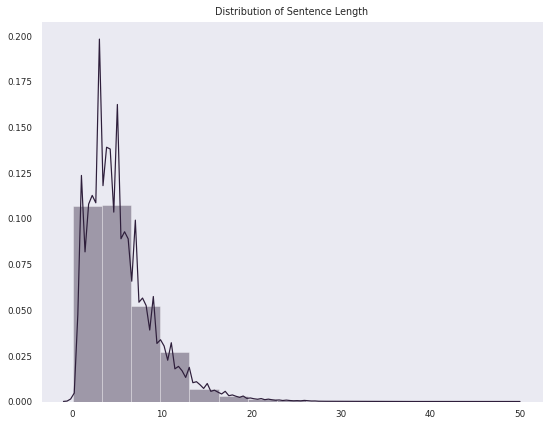

count    65569.000000
mean         5.470649
std          3.800854
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         49.000000
Name: s_len, dtype: float64

In [14]:
plt.figure(figsize=(9,7))
sns.distplot(tuple(sentences1.s_len),bins=15)
plt.title('Distribution of Sentence Length')
plt.show()

sentences1.s_len.describe()

In [15]:
sentences1.shape

(65569, 6)

Currently we have 65000+ sentences that need to be vectorized and processed. In order to avoid complications with the vectorization and clustering, I will set a minimum word length for each sentence.
    
    - Create a list of index numbers to keep
    - Replace the dataframe with only desired index numbers
    - Convert lists of tokens to strings
    - Remove '-pron-' token created by spacy
We've set a window of 9 to 16 sentence size. This will reduce the number of sentences to around 10,000, while hopefully still preserving the substance of the texts.  This is really a compromise. Vectorizing and processing 66,000 sentences is computationally and time intensive, so we want the reduction. Plus, I don't want the model to think sentences like "That's Right" or "Now, what?" or any other short meaningless statement you would hear in a math lecture are more important than longer sentences describing a concept.

In [16]:
#list index numbers to keep
to_keep = [ i for i in sentences1.index if len(sentences1.sents[i]) >= 9 and len(sentences1.sents[i]) <= 16]
#keep index numbers,execute other steps
sentences1 = sentences1.iloc[to_keep]
sentences1['text'] = [' '.join(i) for i in list(sentences1.sents)]
sentences1.text = [ re.sub("-pron-","",sentences1.text[i]) for i in to_keep]
sentences1.reset_index(inplace=True, drop=True) #reset the index here
sentences1.sample(5, random_state=43)

filename Professor     Subject  \
3177  leighton14dandcs  Leighton     CS Math   
6641   rigolletstats19  Rigollet  Statistics   
9408       strangmeng6    Strang   Mech. Eng   
7650       sochernlp13    Socher         NLP   
2590     jerisoncalc21   Jerison    Calculus   

                                                   sdoc  \
3177  (       , PROFESSOR, :, This, week, we, are, g...   
6641  (    , to,    , PROFESSOR, :, ,, bunch, of, x,...   
9408  (   , To, make, a, donation, ,, or, to,    , P...   
7650  ( , Network, ,, there, is, actually, a, whole,...   
2590  (   , To, make, a, donation, ,, or, to,    , P...   

                                                  sents  s_len  \
3177  [all, right, like, know, long, till, world, en...      9   
6641  [think, realization, guy, go, cloud, n, point,...      9   
9408  [so, -pron-, want, sum, square, -pron-, think,...      9   
7650  [well, model, go, see, small, norm, feature, v...     11   
2590  [and, -pron-, think, order, answer, question, ...     12   

                                                   text  
3177        all right like know long till world end t64  
6641        think realization guy go cloud n point r d.  
9408     so  want sum square  think cos(theta sin(theta  
7650  well model go see small norm feature vector z ...  
2590  and  think order answer question  go detail me...

In [17]:
sentences1.shape

(10156, 7)

### Split the data 
 - We need to split the data for training and testing purposes, we will set X as the sentences and Y as the labels to maintain traceability

In [18]:
#Split the data into train and test set.
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

### Tf-Idf Vectorization of the sentences
    Right now we are going to create numerical vectors for each sentence using the Tf-idf feature from the genism library.

In [19]:
#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 15
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True 
                            )

In [20]:
#Fit vectorizer and transform X_train to vectors
X_train_tfidf = vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_train_tfidf_csr = X_train_tfidf.tocsr() #Reshapes the vectorizer output into something people can read
n = X_train_tfidf_csr.shape[0] #number of sentences
tfidf_bysent = [{} for _ in range(0,n)] #A list of dictionaries, one per sentence
terms = vectorizer.get_feature_names() #List of features
#for each sent, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]
print('Original sentence:', X_train[4421],y_train[4421])
print('Tf_idf vector:', tfidf_bysent[4421])

Number of features: 453
Original sentence: after find eigenvalue lambda omega squared know omegas find eigenvector ['Strang' 'Mech. Eng' 'strangmeng10']
Tf_idf vector: {'know': 0.3611194426533281, 'omega': 0.5501703808312975, 'squared': 0.5194008067903516, 'lambda': 0.5450945808749401}


### Calculating the cosine similarity of each sentence 

from wiki:
   " Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0,π] radians. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors oriented at 90° relative to each other have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. "
https://en.wikipedia.org/wiki/Cosine_similarity

We will use this metric to asses similarity of sentences.

In [21]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
df_similarity = pd.DataFrame(cosine_similarity(X_train_tfidf), index=range(len(X_train)),
                            columns=X_train) # set sentneces as the columns


In [22]:
df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

In [23]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [24]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
1672                                           0.709474                         
5563                                           0.702142                         
6827                                           0.686053                         
6662                                           0.649410                         

                                      Original_Sentence Professor  \
4421  after find eigenvalue lambda omega squared kno...    Strang   
1672  and denominator omega nought squared minus ome...   Mattuck   
5563  ay = lambda*y multiply a. a squared*y lambda*a...    Strang   
6827  omega square root omega nought squared minus p...   Mattuck   
6662     omega d omega square plus omega nought squared   Mattuck   

                     Subject       filenames  mean_similarity  
4421               Mech. Eng    strangmeng10         0.013513  
1672  Differential Equations  mattuckdifeq10         0.013710  
5563               Mech. Eng     strangmeng6         0.006807  
6827  Differential Equations  mattuckdifeq10         0.015854  
6662  Differential Equations  mattuckdifeq10         0.012165

### Use PCA to reduce dimensionality and visualize results

In [25]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(X_train_tfidf.todense())

pca_kclusters = pd.DataFrame()
pca_kclusters['original'] = X_train
pca_kclusters['Professor'] = y_train[:,0]
pca_kclusters['Subject'] = y_train[:,1]
pca_kclusters['PCA_1'] = Y[:,0]
pca_kclusters['PCA_2'] = Y[:,1]
pca_kclusters['filename'] = y_train[:,2]
df_similarity['PCA_1'] = Y[:,0]
df_similarity['PCA_2'] = Y[:,1]

In [26]:
sns.set_context('notebook')
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Subject',data=pca_kclusters,palette='mako_r')
plt.show()
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Professor',data=pca_kclusters,palette='mako')
plt.show()

Now that the dimension has been reduced to two, we can scatter the results and color the cluster label, for a given number of clusters.
I chose the folowing as the number of clusters to test [5, 6, 7, 8, 9, 10, 11, 25, 93]. 
10,11,93 because it is the number of professors,subjects,lectures respectively.
For good measure I try 5 (lower than the desired cluster amount) and 25 (higher than the desired number).


The desired number of clusters is based on number of subjects and number of professors. >> 10 or 11

### KMeans Clustering

We will iterate over the list of cluster numbers, clustering and plotting the two PCA components with the correst cluster assignment as the hue of each point.

Number of Clusters: 5

Silhouette avg 5 clusters: 0.49544346950090223




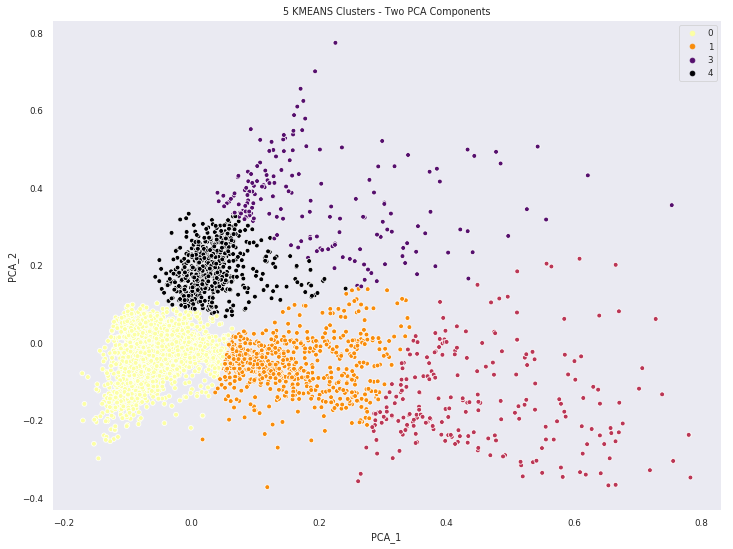

Number of observations per cluster:
0    5867
1     700
4     615
2     253
3     182
dtype: int64
Time: 2.5780036449432373 seconds.

Number of Clusters: 6

Silhouette avg 6 clusters: 0.06039477170716255




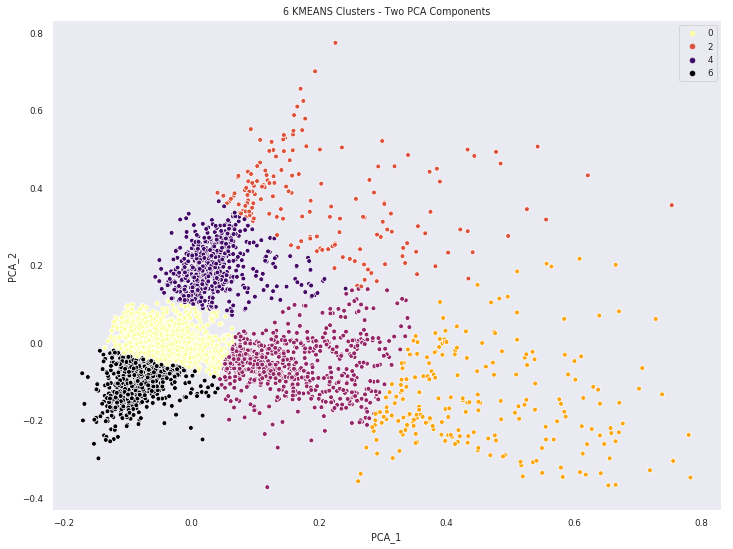

Number of observations per cluster:
0    4956
5     942
3     687
4     609
1     252
2     171
dtype: int64
Time: 2.220233917236328 seconds.

Number of Clusters: 7

Silhouette avg 7 clusters: 0.08325892148754048




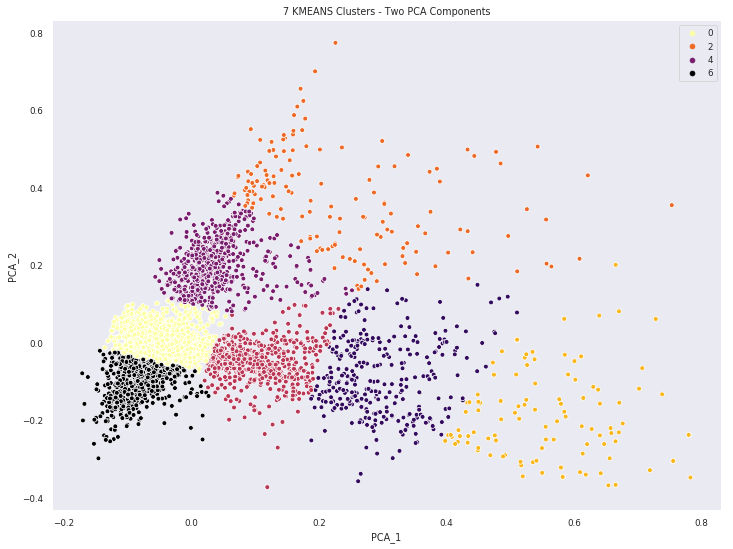

Number of observations per cluster:
0    4888
6     917
4     630
3     592
5     310
2     155
1     125
dtype: int64
Time: 2.3162338733673096 seconds.

Number of Clusters: 8

Silhouette avg 8 clusters: 0.03572482170738569




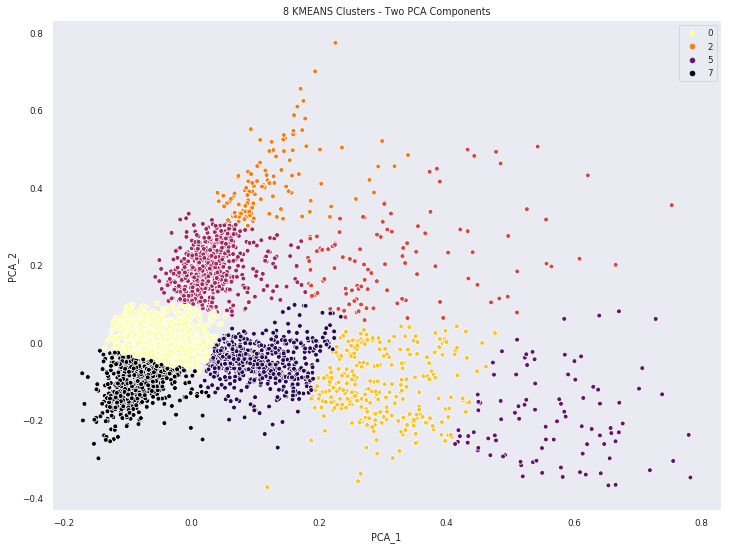

Number of observations per cluster:
0    4897
7     903
6     593
4     590
1     290
5     116
2     115
3     113
dtype: int64
Time: 2.2340500354766846 seconds.

Number of Clusters: 9

Silhouette avg 9 clusters: -0.10141415514431731




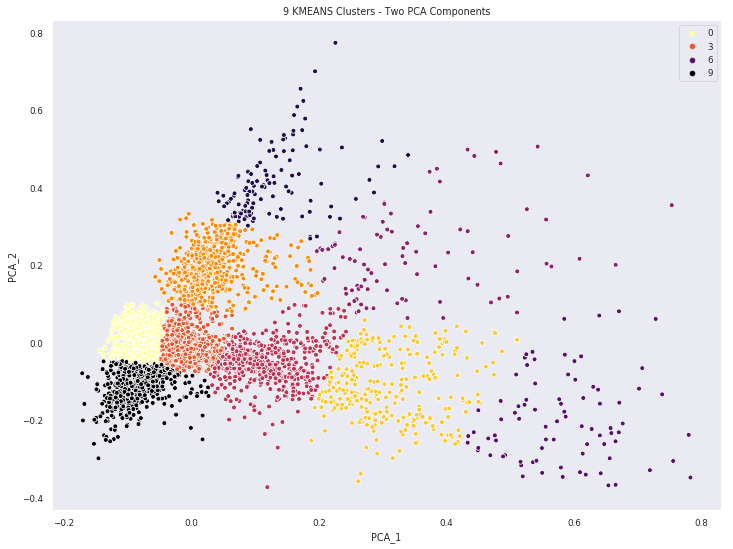

Number of observations per cluster:
3    2829
0    2273
8     753
2     596
4     561
1     292
7     119
6     100
5      94
dtype: int64
Time: 2.352707624435425 seconds.

Number of Clusters: 10

Silhouette avg 10 clusters: -0.10332064018309271




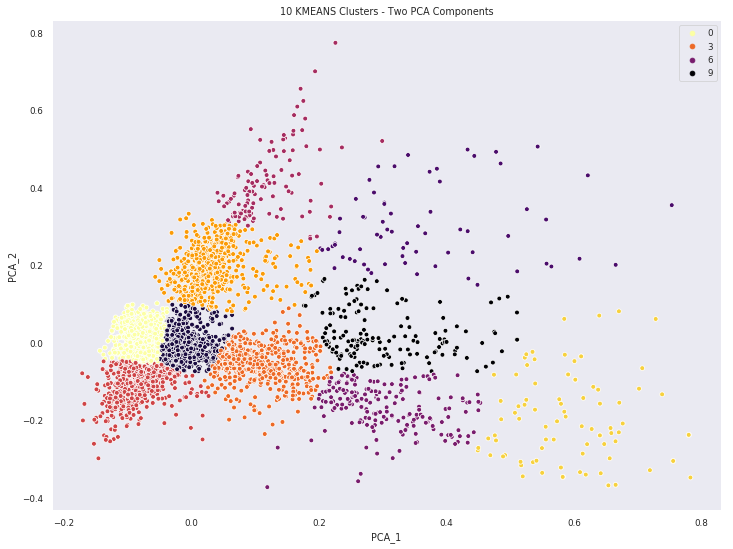

Number of observations per cluster:
8    2786
0    2295
4     765
2     593
3     540
6     195
9     164
5     113
1      96
7      70
dtype: int64
Time: 2.421053171157837 seconds.

Number of Clusters: 11

Silhouette avg 11 clusters: -0.09893096778565112




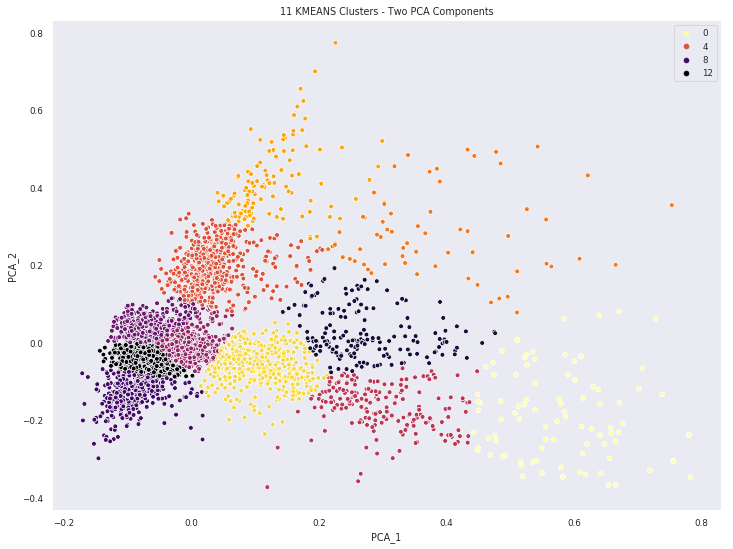

Number of observations per cluster:
6     2509
10    1736
7     1180
4      577
1      526
8      423
5      197
9      175
2      117
0      110
3       67
dtype: int64
Time: 2.256296396255493 seconds.

Number of Clusters: 25

Silhouette avg 25 clusters: -0.23141310719211544




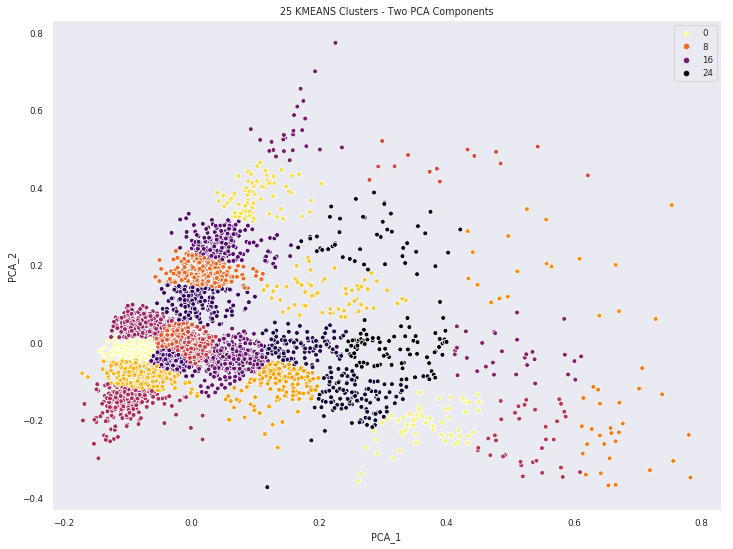

Number of observations per cluster:
9     1604
19    1087
0     1032
11     767
4      539
14     501
17     322
8      264
18     201
13     200
5      175
20     172
dtype: int64
Time: 2.9768261909484863 seconds.

Number of Clusters: 93

Silhouette avg 93 clusters: -0.4504797030178997




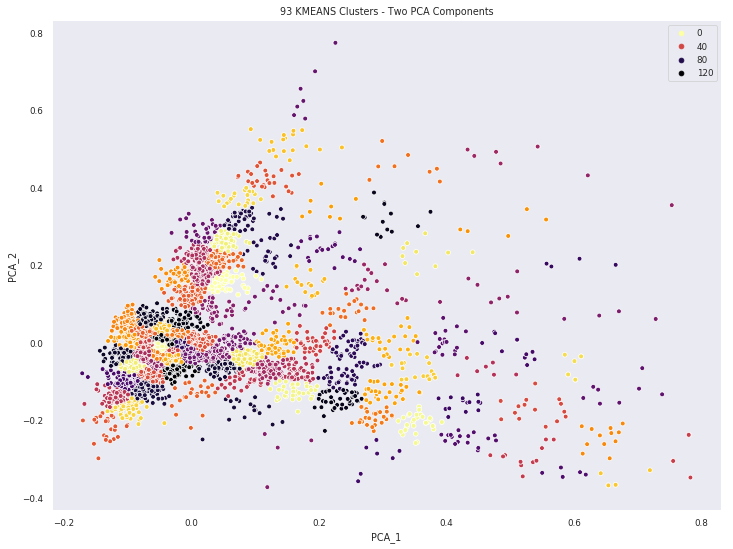

Number of observations per cluster:
92    531
1     461
77    424
90    399
40    398
42    396
26    346
28    283
50    242
33    233
17    201
55    198
dtype: int64
Time: 4.972405910491943 seconds.



In [27]:
sns.set_context('paper')
k_clusters = [5,6,7,8,9,10,11,25,93]
for i in k_clusters:
    t1 = time.time()
    modelk_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette avg {} clusters:'.format(i), silhouette_score(Y, modelk_clusters, metric='cosine'))
    print('\n')
    pca_kclusters['cluster_k='+str(i)] = modelk_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue=modelk_clusters, data=pca_kclusters,palette='inferno_r')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} KMEANS Clusters - Two PCA Components".format(i))   
    plt.show()    
    print('Number of observations per cluster:')
    print(pd.value_counts(modelk_clusters)[:12])
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

Visualize the text of a random cluster

In [28]:
t22 = time.time()

In [29]:
cluster6 = pca_kclusters[pca_kclusters['cluster_k=10'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_kclusters[pca_kclusters['cluster_k=10'] == 6],
                palette='inferno_r')
for label, x, y in zip(cluster6.original,cluster6.PCA_1,cluster6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

plt.xlim(.1,.2)
plt.ylim(.45,.55)
plt.title('Sk-learn kmeans Cluster No. 7 of 10')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()    


So far its hard to tell what the algorithm is doing. The silhouette scores are pretty horrible. They range from .5 to -.47. A large loss in score occurs between 5 and 6 clusters. For this cluster at least almost every sentence contains the word 'time.'

### Vectorization of Sentences with Doc2Vec
Learn paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”.

The algorithms use either hierarchical softmax or negative sampling; see Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean: “Efficient Estimation of Word Representations in Vector Space, in Proceedings of Workshop at ICLR, 2013” and Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean: “Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013”.
https://radimrehurek.com/gensim/models/doc2vec.html

When training a Doc2Vec model, both word representations and paragraph representations are stored. Using the vector representation of each sentence in the model, we can then attempt to cluster the data again and compare the results with our tf-idf vectors. 

#### Important features of the Doc2Vec Class
    -Word2VecKeyedVectors – This object essentially contains the mapping between words and embeddings. After training, it can be used directly to query those embeddings in various ways.
    
    - Doc2VecKeyedVectors – This object contains the paragraph vectors. Remember that the only difference between this model and Word2Vec is that besides the word vectors we also include paragraph embeddings to capture the paragraph.

    In this way we can capture the difference between the same word used in a different context. For example we now have a different representation of the word “leaves” in the following two sentences

    1. Manos leaves the office every day at 18:00 to catch his train
    2. This season is called Fall, because leaves fall from the trees.

    In a plain Word2Vec model the word would have exactly the same representation in both sentences, in Doc2Vec it will not.


In [30]:
#Split the data exactly the way it was previously split
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [31]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [32]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [33]:
'''#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=100, # 100 dimensions should be fine for our corpus
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=7, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("math_lects2.model")
print("Model Saved")
print("Time: {}".format(t2-t1))'''

'#Train the model\n\n#max training epochs\nmax_epochs = 100\n\nmodel = Doc2Vec(vector_size=100, # 100 dimensions should be fine for our corpus\n                alpha=.025, #initial learning rate\n                min_alpha=0.00025, #learning rate drops linearly to this\n                min_count=7, #ignores all words with total frequency lower than this.\n                dm =1) #algorith 1=distributed memory\n\n#Build vocabulary from a sequence of sentences (can be a once-only generator stream).\nmodel.build_vocab(tagged_data)\n\n#train 100 epochs and save the model\nt1 = time.time()\nfor epoch in range(max_epochs):\n    print(\'iteration {0}\'.format(epoch))\n    model.train(tagged_data,\n                total_examples=model.corpus_count,\n                epochs=model.iter)\n    # decrease the learning rate\n    model.alpha -= 0.0002\n    # fix the learning rate, no decay\n    model.min_alpha = model.alpha\nt2 = time.time()    \nmodel.save("math_lects2.model")\nprint("Model Saved")\npr

In [34]:
#load the saved model
model= Doc2Vec.load("math_lects2.model")

In [35]:
X_train.shape

(7617,)

In [36]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])
print(tagged_data[4421])
print(model.docvecs['4421'])

TaggedDocument(['after', 'find', 'eigenvalue', 'lambda', 'omega', 'squared', 'know', 'omegas', 'find', 'eigenvector'], ['4421'])
[ 1.2728446e+00  3.4422400e+00  3.2598712e-02  4.2461094e-01
 -7.8580344e-01  9.2627704e-01  4.1250423e-01 -1.1120907e+00
  4.7397023e-01  2.4435365e-01  2.8793287e-01 -1.4638776e+00
 -4.7965446e-01 -4.8024976e-01 -7.0061153e-01  1.1146189e+00
  1.3136872e+00  1.7012703e+00  2.9906127e-01  4.2717859e-01
 -5.7784784e-01 -3.5227820e-01  4.8567411e-01 -7.7499968e-01
  2.0417672e-01  3.4177810e-01  1.9500971e+00  1.2788541e+00
  3.8816601e-01 -7.5848138e-01 -9.3545243e-02 -2.6171798e-01
  1.3904992e+00  1.4267498e-01  1.6693540e+00  1.3218819e+00
  1.9264374e+00  3.3820164e-01 -9.2997760e-01 -2.4959950e+00
 -1.4931414e+00 -8.2523501e-01  2.1535767e-02 -1.6089793e-01
  3.7526530e-01  1.4018161e+00 -5.5778140e-01  3.8988107e-01
 -8.4110492e-01 -2.6553827e-03  2.4658056e-01 -1.6841555e-01
 -5.0418490e-01 -2.9320180e-01  1.3143194e-01  2.5414379e+00
 -1.5319964e+00  

In [37]:
vecs.shape

(7617, 100)

In [38]:
### Calculate Similarity of sentences in the Doc2Vec model 

In [39]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
d2v_sim = pd.DataFrame(cosine_similarity(vecs), index=range(len(X_train)),
                            columns=X_train) # set sentneces for the rows and columns
#calculate the mean similarity of each sentence
d2v_sim.insert(0, 'mean_similarity', d2v_sim.mean(axis=1))

In [40]:
#add identification to similarity dataframe
d2v_sim['Professor'] = y_train[:,0]
d2v_sim['Subject'] = y_train[:,1]
d2v_sim['Original_Sentence'] = X_train
d2v_sim['filenames'] = y_train[:,2]

In [41]:
#check benchmark sentence
sentence = X_train[4421]
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
641                                            0.537138                         
549                                            0.536796                         
6607                                           0.510963                         
4808                                           0.509065                         

                                      Original_Sentence Professor     Subject  \
4421  after find eigenvalue lambda omega squared kno...    Strang   Mech. Eng   
641    kind search see find large element find small...   Devadas  Algorithms   
549      and course eig command matlab find y 's lambda    Strang   Mech. Eng   
6607  and eigenvector know large carry large varianc...  Rigollet  Statistics   
4808  so implicit differentiation technique allow di...   Jerison    Calculus   

            filenames  mean_similarity  
4421     strangmeng10         0.112888  
641     devadasalgos6         0.130273  
549       strangmeng6         0.161898  
6607  rigolletstats19         0.154353  
4808     jerisoncalc5         0.148722

We  can see that the similar sentences in the Doc2Vec model differ from those in the TFIDF similarity matrix.  A noticable difference is the TFIDF vectors tend to be more similary based on word frequency (as expected). In the first similarity comparison for sentence 4421, we can see that the most similar sentences are those with 'omega'. However in the Doc2Vec it appears to be incorporating multiple words. In the results directly above, we can see that the most similar sentences contains the word 'find' followed by other sentences that contain various words from the benchmark sentence (eigenvector and lambda)

#### Reduce dimensionality of Doc2Vec sentences with PCA and plot results

In [42]:
vecs.shape

(7617, 100)

In [43]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(vecs)

pca_d2vclusters = pd.DataFrame()
pca_d2vclusters['original'] = X_train
pca_d2vclusters['Professor'] = y_train[:,0]
pca_d2vclusters['Subject'] = y_train[:,1]
pca_d2vclusters['PCA_1'] = Y[:,0]
pca_d2vclusters['PCA_2'] = Y[:,1]
pca_d2vclusters['filename'] = y_train[:,2]

Number of Clusters: 5

Silhouette Score 5 clusters: 0.3082093560337892




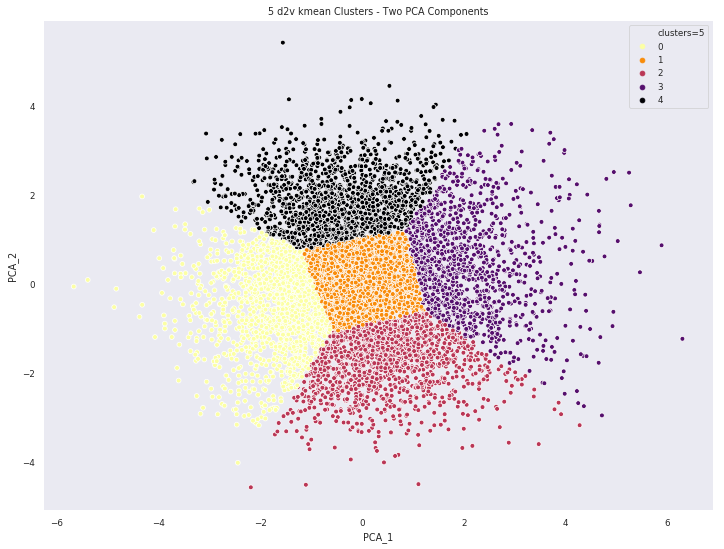


Avg Obs per cluster: 1523.4

Number of observations per cluster:
1    1938
0    1543
2    1468
4    1463
3    1205
dtype: int64
Time: 2.3582913875579834 seconds.

Number of Clusters: 7

Silhouette Score 7 clusters: 0.27483584687354606





Avg Obs per cluster: 1088.142857142857

Number of observations per cluster:
0    1890
2    1153
3    1077
5    1030
4     851
6     825
1     791
dtype: int64
Time: 2.6469662189483643 seconds.

Number of Clusters: 9

Silhouette Score 9 clusters: 0.14151283744653137





Avg Obs per cluster: 846.3333333333334

Number of observations per cluster:
0    1520
6    1097
7    1019
5     809
8     802
2     762
4     678
3     489
1     441
dtype: int64
Time: 3.1069908142089844 seconds.

Number of Clusters: 10

Silhouette Score 10 clusters: 0.06186278779750881





Avg Obs per cluster: 761.7

Number of observations per cluster:
7    1203
3    1108
0     969
5     851
8     791
2     665
1     620
6     528
9     470
4     412
dtype: int64
Time: 2.9276881217956543 seconds.

Number of Clusters: 11

Silhouette Score 11 clusters: -0.002421682695663556





Avg Obs per cluster: 692.4545454545455

Number of observations per cluster:
4     1147
3      993
0      869
2      859
5      723
10     651
1      613
6      584
7      445
8      390
9      343
dtype: int64
Time: 2.8815391063690186 seconds.

Number of Clusters: 25

Silhouette Score 25 clusters: -0.24886838502941092




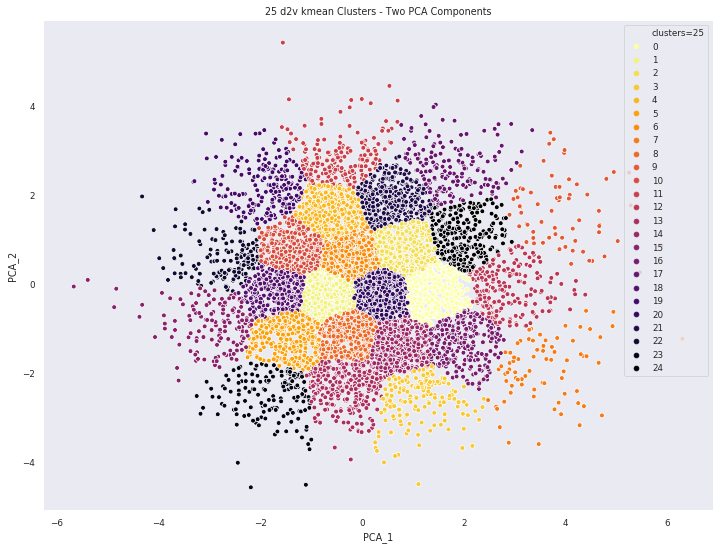


Avg Obs per cluster: 304.68

Number of observations per cluster:
1     608
20    607
6     490
8     454
14    431
4     421
18    401
2     378
0     368
21    357
10    357
5     353
dtype: int64
Time: 4.144788026809692 seconds.



In [44]:
sns.set_context('paper')
d2v_clusters = [5,7,9,10,11,25]
for i in d2v_clusters:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Y, d2v_clusters, metric='cosine'))
    print('\n')
    pca_d2vclusters['clusters='+str(i)] = d2v_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_d2vclusters,palette='inferno_r',legend='full')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_clusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

The two dimensional shape of the doc2vec vectors seems to have more symmetry than that of the TFIDF vectors.
Also another remark is the 5 ness of the clusters, they seem to be pentagonal.

Lets take a look at a cluster from one of the iterations and visualize the text.

In [45]:
clusterd2v6 = pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6],
                palette='inferno_r')
for label, x, y in zip(clusterd2v6.original,clusterd2v6.PCA_1,clusterd2v6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

plt.xlim(-2,-3)
plt.ylim(.44,.525)
plt.title('Sk-learn kmeans Cluster No. 7 of 11 Doc2Vec')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

So  far we have seen the K means algorithm create clusters of different sizes for both TF-IDF vectorization and Doc2Vec vecotrization.

The results of the silhouette scores were not very good. Many of them were close to zero for my desired clusters (10 or 11).
According to the documentation for sklearn silhouette score:
"Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster."

One observation to be made at this point is that the clusters seem to contain sentences that just have similar word use(see above).
How ever the clusters do not seem to line up directly with the similarity scores.
See below for an example.

In [46]:
#display sentences from referenced lecture
d2v_sim['cluster11'] = pca_d2vclusters['clusters=11']
sentence = 'p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.'
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','cluster11']].sort_values(by=[sentence],ascending=False)[:5]

p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.  \
6061                                           1.000000                                     
6642                                           0.547743                                     
2441                                           0.525432                                     
4451                                           0.511138                                     
5611                                           0.504857                                     

                                      Original_Sentence Professor   Subject  \
6061  p statement girl g reject boy b girl g suitor ...  Leighton   CS Math   
6642       so girl g bad m tma be mate m let b mate tma  Leighton   CS Math   
2441       there be rogue couple m. b g rogue couple m.  Leighton   CS Math   
4451  so believe law cosine tell yes proof adotb equ...    Auroux  Calculus   
5611                all right let let b prime mate g m.  Leighton   CS Math   

                filenames  cluster11  
6061  leighton7graphmatch          3  
6642  leighton7graphmatch          5  
2441  leighton7graphmatch          0  
4451         aurouxmcalc1          1  
5611  leighton7graphmatch          4

The next step is to define the model and examine each cluster

In order to proceed, we must chose a vectorization method, a clustering method and in our case, number of clusters.
So far the Doc2Vec seems to be doing a better job in terms of vectorization.  When comparing the TFIDF and D2V scatter shapes after PCA to two components, the Doc2Vec has better geometry.  For clustering, the K means algorithm is one of the only algorithms that is viable for this dataset, as it lets me define n_clusters and it is scalable. Other clustering algorithms, resulted in errors as the algorithms consistently determine that one cluster is optimal.
So for now, I have chosen Doc2Vec for vectorization and KMeans clustering for the clustering algorithm. Let's run the KMeans algorithm on the full vectors instead of the PCA version to determine how many clusters we want to define.

### Determine optimal number of clusters

In [47]:
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [48]:
#this loop iterates over a range of 10 to 46, in order to collect scores from each cluster
nclusts =[]
sscores = [] 
avgobs = []
obsstd = []
d2v_full = range(10,46,2)
for i in d2v_full:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(vecs)    
    nclusts.append(i)
    sscores.append(silhouette_score(vecs, d2v_clusters, metric='cosine'))
    avgobs.append(pd.value_counts(d2v_clusters).mean())
    obsstd.append(pd.value_counts(d2v_clusters).std())
    print('N. Clusters: {}, done!'.format(i))

N. Clusters: 10, done!
N. Clusters: 12, done!
N. Clusters: 14, done!
N. Clusters: 16, done!
N. Clusters: 18, done!
N. Clusters: 20, done!
N. Clusters: 22, done!
N. Clusters: 24, done!
N. Clusters: 26, done!
N. Clusters: 28, done!
N. Clusters: 30, done!
N. Clusters: 32, done!
N. Clusters: 34, done!
N. Clusters: 36, done!
N. Clusters: 38, done!
N. Clusters: 40, done!
N. Clusters: 42, done!
N. Clusters: 44, done!


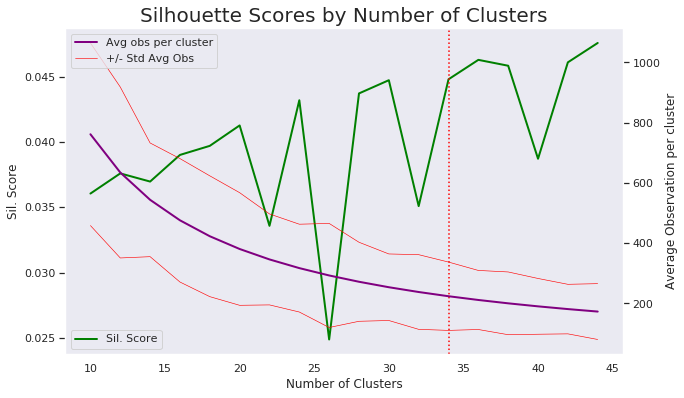

In [49]:
#Visualize Results
obsstd1 = [ i+j for i,j in zip(avgobs,obsstd)]
stdneg = [ i-j for i,j in zip(avgobs,obsstd)]

sns.set_context('notebook')
fig, ax = fig, ax = plt.subplots(figsize=(10,6))

ax2 = ax.twinx()
ax = sns.lineplot(nclusts, sscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(nclusts, avgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(nclusts,obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(nclusts,stdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=34,color='r',linestyle='dotted')
ax.legend(loc='lower left')
ax2.legend(loc='upper left')
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
#
plt.show()

In this chart we can see that the silhouette scores are pretty volitile (and low). The objective is to pick a cluster number with a relatively high silhouette score and a relatively even distribution of observations per cluster.  The chart seems to indicate that cluster numbers of ~25-40 appear to bethe best selection, and the red bands straddling the purple line indicates lower variance which suggests the distribution of observations per cluster is evening out.

At this point, I have decided to disregard the pre determined number of clusters (10+11) and elect to use 34 clusters. I chose 34 because of the score.

Lets reduce the dimensionality using both PCA and this time also t-SNE, (as it is said be good for visualization of texts.)

" t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results."

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

#### 34 Clusters reduced to two PCA components
    1. Reduce dimensionality to two components
    2. Cluster the data in 34 clusters using KMeans clustering
    3. Plot the results

Number of Clusters: 34




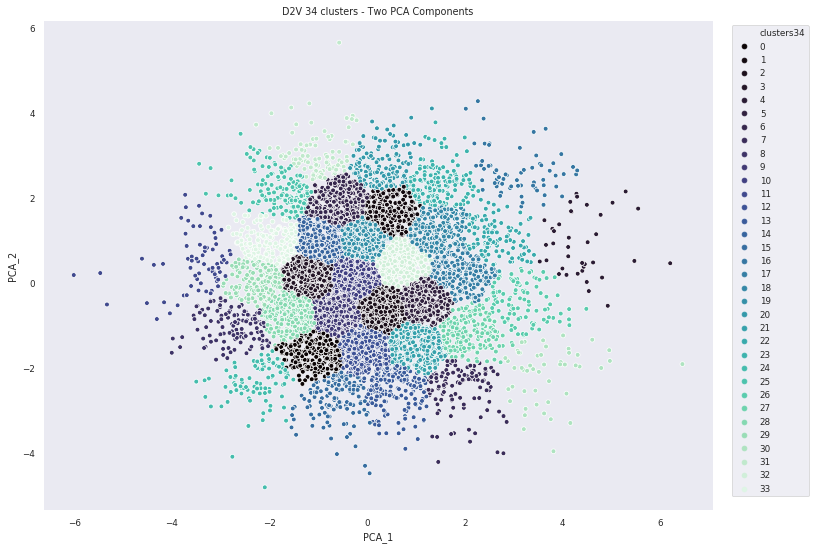

In [50]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)

#fit transform doc2vec word vectors
Y34 = pca.fit_transform(vecs)

#create dataframe for plotting, add comoonents,labels
pca_d2vclusters34 = pd.DataFrame()
pca_d2vclusters34['original'] = X_train
pca_d2vclusters34['Professor'] = y_train[:,0]
pca_d2vclusters34['Subject'] = y_train[:,1]
pca_d2vclusters34['PCA_1'] = Y34[:,0]
pca_d2vclusters34['PCA_2'] = Y34[:,1]
pca_d2vclusters34['filename'] = y_train[:,2]

#cluster the data
d2v_clusters34 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(Y34)    
print('Number of Clusters: 34')
# calculate and print silhouette average scores
#print('\nSilhouette Score {} clusters:'.format(silhouette_score(Y30, d2v_clusters30, metric='cosine'))
print('\n')
sns.set(context='paper',style='dark')
pca_d2vclusters34['clusters34'] = d2v_clusters34
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters34', data=pca_d2vclusters34,palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("D2V 34 clusters - Two PCA Components")   
plt.show()

#### 34 Clusters reduced to two PCA components
    1. Cluster the data in 34 clusters using KMeans clustering
    2. Reduce dimensionality to two components 
    3. Plot the results

In [51]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2, random_state=43)

pca_d2vclusters34 = pd.DataFrame()
pca_d2vclusters34['original'] = X_train
pca_d2vclusters34['Professor'] = y_train[:,0]
pca_d2vclusters34['Subject'] = y_train[:,1]

d2v_clusters34 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(vecs) 
#fit transform doc2vec word vectors
Y34 = pca.fit_transform(vecs)

#create dataframe for plotting, add comoonents,labels

pca_d2vclusters34['PCA_1'] = Y34[:,0]
pca_d2vclusters34['PCA_2'] = Y34[:,1]
pca_d2vclusters34['filename'] = y_train[:,2]

#cluster the data
   
print('Number of Clusters: 34')
# calculate and print silhouette average scores
#print('\nSilhouette Score {} clusters:'.format(silhouette_score(Y30, d2v_clusters30, metric='cosine'))
print('\n')
sns.set(context='paper',style='dark')
pca_d2vclusters34['clusters34'] = d2v_clusters34
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters34', data=pca_d2vclusters34,palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("D2V 34 clusters - Two PCA Components")   
plt.show()

Number of Clusters: 34




We can see that when we reduce the original data to two clusters and then cluster the results, each verticle line of points shares multiple cluster groups, where as clustering the data first and then reducing the dimensionality leads to more consist cluster assignments for a given line.

Lets do the same with t-SNE

#### 34 clusters reduce with t-SNE to two components
    1. Cluster the data into 34 clusters with KMeans algorithm
    2. Reduce dimensionality to two components
    3. Plot the results

In [52]:
t1 = time.time()
tsne2 = TSNE(n_components=2, random_state=43, metric='cosine')
tsne2_d2v = pd.DataFrame()
tsne2_d2v['original'] = X_train
tsne2_d2v['Professor'] = y_train[:,0]
tsne2_d2v['Subject'] = y_train[:,1]
tsne2_d2v['filename'] = y_train[:,2]

sns.set_context('paper')

#Reduce dimentionality
Yt = tsne2.fit_transform(vecs)
#Cluster the reduced data
d2v_clusters2 = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(Yt)    
print('Number of Clusters: 24')
# calculate and print silhouette average scores
print('\nSilhouette Score:', silhouette_score(vecs, d2v_clusters2, metric='cosine'))
print('\n')


tsne2_d2v['TSNE_1'] = Yt[:,0]
tsne2_d2v['TSNE_2'] = Yt[:,1]
tsne2_d2v['cluster'] = d2v_clusters2

#plot the results
plt.figure(figsize=(12,9))
sns.set_context('notebook')
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='cluster', data=tsne2_d2v, palette='mako')
plt.legend(loc='upper right')
# label the axes and set the chart title  
plt.title("34 KMeans Clusters with T-SNE 2 Components")
plt.show()

t2 = time.time()
print("Time: {} seconds.\n".format(t2-t1))



Number of Clusters: 24

Silhouette Score: -0.009573552766596




Time: 179.37733626365662 seconds.



In [ ]:
#instantiate TSNE, set up a dataframe for graphing
tsne = TSNE(n_components=2,random_state=43)
tsne_d2v = pd.DataFrame()
tsne_d2v['original'] = X_train
tsne_d2v['Professor'] = y_train[:,0]
tsne_d2v['Subject'] = y_train[:,1]
tsne_d2v['filename'] = y_train[:,2]

t1 = time.time()
d2v_clusters = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(vecs)    
print('Number of Clusters: 34')
# calculate and print silhouette average scores
print('\nSilhouette Score:', silhouette_score(vecs, d2v_clusters, metric='cosine'))
print('\n')

Yt = tsne.fit_transform(vecs)
tsne_d2v['TSNE_1'] = Yt[:,0]
tsne_d2v['TSNE_2'] = Yt[:,1]
tsne_d2v['cluster'] = d2v_clusters
plt.figure(figsize=(12,9))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='cluster', data=tsne_d2v, palette='mako',legend='full')
plt.legend(loc='upper right', bbox_to_anchor=[1.15,1])
# label the axes and set the chart title  
plt.title("34 KMeans Clusters with T-SNE 2 Components")
plt.show()
print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
print('Number of observations per cluster:')
print(pd.value_counts(d2v_clusters)[:12])    
t2 = time.time()
print("Time: {} seconds.\n".format(t2-t1))

Number of Clusters: 34

Silhouette Score: 0.04483764709436184




In [ ]:
#interesting shape!

#### Select a few clusters and look at sentences

In [ ]:
ts = tsne_d2v.copy()
keeps = [ i for i in ts.index if ts.cluster[i] >= 1 and ts.cluster[i] <= 9]
ts = ts.iloc[keeps]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
ax = sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='cluster', 
                data=ts,
                palette='mako')
rect = patches.Rectangle((-33,-8),15,12,linewidth=3,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
#for label, x, y in zip(tsned2v33.original,tsned2v33.TSNE_1,tsned2v33.TSNE_2):
    #plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

#plt.xlim(-2,2)
#plt.ylim(-10,10)

plt.title('KMeans Clusters 0 through 9 Doc2Vec- Two TSNE')
plt.legend(bbox_to_anchor=[1.2,1],loc='upper right')
plt.show() 

plt.show()

In [ ]:
#look at the intersection of the three clusters

In [ ]:
tsned2v33 = tsne_d2v[tsne_d2v['cluster'] <= 4]
plt.figure(figsize=(10,6))
sns.set_context('notebook')
ax = sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='Subject', 
                data=ts,
                palette='mako', s=75)
for i, clust in enumerate(tsned2v33.cluster):
    colors=['r','b','g','purple','orange','teal','c','m','forestgreen','orangered','limegreen']
    ltsned2v33 = ts[ts.cluster == i]
    for label, x, y in zip(ltsned2v33.original,ltsned2v33.TSNE_1,ltsned2v33.TSNE_2):
        plt.annotate(label, xy=(x, y), xytext=(7, 2), color=colors[i], textcoords='offset points',fontsize=10)

plt.xlim(-29,-26.5)
plt.ylim(-6,-1)
plt.title('3 Cluster Sample by Cluster and Subject')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

### Intracluster similarity of sentences
The subjects of each cluster aren't clear yet. We need to look at each cluster and examine how similar it's sentences are to each other. To do this we will use the cosine similarity matrix to calculate the intracluster similarity of each sentence Then we will visually inspect the results to determine any patterns, topics etc.

In [ ]:
#We need to add the cluster numbers to the vecs dataframe
subsprofs = pd.DataFrame(y_train)
subsprofs['cluster_no'] = d2v_clusters
subsprofs[3] = X_train
vecs['cluster_no'] = d2v_clusters
for_sims = pd.DataFrame(X_train)
for_sims['cluster_no'] = d2v_clusters

In [ ]:
# this function iterates over clusters and calculates the average cosine similarity score of sentences
#For each cluster, a dictionary stores cluster level information as keys and returns a data frame
#with the 'num_sents'(int) most related sentences as rows and the lecture source and intracluster mean similarity
#as columns
n_clusters = 34
def get_similarities(num_sents):    
    sim_sents = OrderedDict()
    lects = OrderedDict()
    mean_sims = {}
    
    # iterate over clusters
    for i in range(n_clusters):
        tmpdf = vecs[vecs.cluster_no == i]
        tmpdf = tmpdf.drop(['cluster_no'],1)
        tmp1 = for_sims[for_sims.cluster_no == i ]
        tmp1 = tmp1.drop(['cluster_no'],1)
        # calculate cosine similarity with Sklearn's cosine_similarity method and store in dataframe
        df_sim = pd.DataFrame(cosine_similarity(tmpdf), index=range(len(tmp1)), columns=tmp1)          
        # insert a column with the average similarity score of each row in the similarity matrix
        df_sim.insert(0, 'mean_similarity', df_sim.mean(axis=1)) 
        df_sim.insert(0, 'lecture', subsprofs[subsprofs.cluster_no == i][2].reset_index(drop=True))
        df_sim.insert(0, 'original_sentence', tmp1.reset_index(drop=True))
        # calculate the cluster's global average similarity score
        mean_similarity = df_sim.mean_similarity.mean()        
        # store the cluster's global average similarity score in a dictionary
        mean_sims['cluster {}'.format(i)] = mean_similarity
        mean_sims['cluster {}'.format(i)] = mean_similarity
        #the DataFrame will be the dictionary value
        top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]
        # store the most similar sentence and the average similarity score of clusters
        sim_sents['cluster_{} | {} sentences | mean similarity: {}'.format(
            i, df_sim.shape[0], mean_similarity)] = top_sents

    return sim_sents, mean_sims

In [ ]:
#call the function for 10 sentences per cluster
ten_sents, mean_sims = get_similarities(10)

In [ ]:
#For each cluster, examine the top 10 most similar sentences in each cluster, along with the source
for i in ten_sents:
    vals = ten_sents[i]
    print('\n{}'.format(i))
    print('\nOriginal Sentence\n\n{}\n\nLecture\n\n{}\\nnMean_sim\n\n{}'.format(
        vals.original_sentence,vals.lecture,vals.mean_similarity))

## Assessing the clusters
 - After calculating the intercluster similarities, some real patterns have started to emerge.
     - The clusters appear to exhibit the same characteristics as before (ie identifying the same word use in different sentences) however, with 34 clusters (we looked at 10, 11 before) some clusters seem to have more relavent similar sentences, even topics. For example, the topic of cluster 33 is clearly probability, not only do the sentences suggest it, but the sentence sources suggest it could be the 'topic' of the cluster. (other sentences pertaining to probability also show up in other clusters) Other clusters on the other hand do not share this 'topic' characteristic.  For instance cluster 25 is a eclectically sourced collection of sentences starting with the word 'but'.
     
   - Note that this analysis was true of the first iteration of the notebook. The clusters do not have the same assigned sentences if ran again. However, after running the Kmeans on the data multiple times, the same sentences seems to get clustered together, just in a different cluster assignments


#### Examining Word Frequencies
     - By extracting the word frequencies and subject/professor/lecture density of each cluster, maybe we can draw new insight.

In [ ]:
#this function removes any 's in the text, tokenizes and stems the word
def clean_lite (text):
    re.sub(" 's",'',text)
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if len(word) > 3]
    words = [word for word in words if word not in default_stopwords]
    #words = [stemmer.stem(word) for word in words]
    return words    

In [ ]:
#add the sentences to our previous dataframe
subsprofs[3] = X_train

In [ ]:
subsprofs.head()

In [ ]:
#iterate over each cluster, 
#convert all sentences in each cluster to one str
#tokenize, stem words, count frequencies of words, subjects, professors and lecture id
for i in sorted(subsprofs.cluster_no.unique()):
    #iterate by cluster
    cluster_df = subsprofs[subsprofs.cluster_no == i].reset_index(drop=True)
    #Make one large string
    cluster_str = ' '.join([ ' '.join([i]) for i in cluster_df[3]]) 
    #run lite cleaner
    cluster_str = clean_lite(cluster_str)
    
    fdist = nltk.FreqDist(cluster_str)
    freq_words = list(Counter(fdist).most_common(5))
    profs = Counter(dict(cluster_df[0].value_counts())).most_common(5)
    subs = Counter(dict(cluster_df[1].value_counts())).most_common(5)
    lects = Counter(dict(cluster_df[2].value_counts())).most_common(5)
    print('Cluster Number: {}, Sentences: {}\n Words and Counts:{}\n Professors: {}\n Subjects:{}\n Lectures: {}\n'.format(\
        i,cluster_df.shape[0],freq_words,profs,subs, lects))

After examing the occurance frequencies of each tokens and their identifying labels, we see some support for our hypothesis. For instance the word probability occurs 184 times, while the next common word is 'equal' with 21 counts. In fact 19 of the 34 clusters have a word that is present at least more than 4 four times than the second most frquently occuring word, in some clusters that rate is almost 10.
 - Clusters with dominant words:
     - 1,3,5,6,7,8,10,14,15,16,19,20,21,24,26,28,30,32,33
 - Clusters with out dominant words include those not listed above. The most common words occur at a rate less than 2 twice the second word, and do not really seem to be related to any particular topic. The word 'actually' shows up alot.
 -  A last observation is the similarities between clusters 30 and 32 where the 2 most common words are 'need' and 'know' - and - 'know' and 'want'. As in 'i need to know x, once i have x i want to y'
 
While this analysis shed some light on new patterns not seen before, we can use another technique called NonNegative Matrix Factorization. We will apply a minMax scaler to that data move all the data points positive between 0 and 1. then for each cluster we will apply the fit and see how the sentences are groups. This is a common way of finding subtopics with clusters.

In [ ]:
#define a function to extract subtopics

def nmf_topics(vec_matrix, num_sents):
    sim_sents = OrderedDict()
    
    for i in range(n_clusters):
        tmp1 = subsprofs[subsprofs.cluster_no == i]
        temp_matrix = vecs
        temp_matrix['cluster_no'] = subsprofs.cluster_no
        temp_matrix = temp_matrix[temp_matrix.cluster_no == i]
        temp_matrix = minmax_scale(temp_matrix.drop(['cluster_no'],1))
        n_comps = int(np.ceil(temp_matrix.shape[0] * .01)) #100 sentences per component
        #Instaniate a NMF instance 

        nmf = NMF(alpha=0.35, 
                  init='nndsvdar', # how starting value are calculated
                  l1_ratio=0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
                  max_iter=400, # when to stop even if the model is not converging (to prevent running forever)
                  n_components=n_comps, 
                  random_state=43, 
                  solver='cd', # Use Coordinate Descent to solve
                  tol=0.0001, # model will stop if tfidf-WH <= tol
                  verbose=1) # amount of output to give while iterating
        components = nmf.fit_transform(temp_matrix)
        df_components = pd.DataFrame(components, index=tmp1[[2,3]])
        df_components.insert(0, 'sentence',tmp1[3])
        df_components.insert(0, 'lecture',tmp1[2].reset_index(drop=True))
                                    
        for col in df_components.columns[2:]:
            top_sents = df_components[col].sort_values(ascending=False)[:num_sents].index
            sim_sents['cluster_{}, component {}'.format(i, col)] = top_sents
        
        print('Cluster {}: {} observations , {} components'.format(i, temp_matrix.shape[0],n_comps))
    
    return sim_sents



In [ ]:
#Call the function
cluster_topics = nmf_topics(vecs, 10)

In [ ]:
#print the first five sentences in each component, t
for key, value in cluster_topics.items():
    print('\n--------------\n',key)
    for i, sent in enumerate(value):
            print('\n{})'.format(i),sent)

Using non negative matrix factorization we can see a bit more similarity in the relationship of common words. For example

In [ ]:
#Split the data exactly the way it was previously split
X = np.array(raw_data['raw_text'])
y = np.array(raw_data[['filename','Professor','Subject']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [ ]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [ ]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [ ]:
'''#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=100, # 100 dimensions should be fine for our corpus
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=7, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("full_lects.model")
print("Model Saved")
print("Time: {}".format(t2-t1))'''

In [ ]:
#load the saved model
model= Doc2Vec.load("full_lects.model")

In [ ]:
end = time.time()
print('Notebook time: {} Minutes'.format((time.time()-glob_time1)/60))

In [ ]:
X_train.shape

In [ ]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])
print(tagged_data[40][:20])
print(model.docvecs['40'])

In [ ]:
vecs.shape

In [ ]:
### Calculate Similarity of sentences in the Doc2Vec model 

In [ ]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
d2v_fullsim = pd.DataFrame(cosine_similarity(vecs), index=range(len(X_train)),
                            columns=X_train) # set sentneces for the rows and columns
#calculate the mean similarity of each sentence
d2v_fullsim.insert(0, 'mean_similarity', d2v_sim.mean(axis=1))

In [ ]:
#add identification to similarity dataframe
d2v_fullsim['Professor'] = y_train[:,1]
d2v_fullsim['Subject'] = y_train[:,2]
d2v_fullsim['Original_Sentence'] = X_train
d2v_fullsim['filenames'] = y_train[:,0]

In [ ]:
#check benchmark sentence
sentence = X_train[4421]
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

We  can see that the similar sentences in the Doc2Vec model differ from those in the TFIDF similarity matrix.  A noticable difference is the TFIDF vectors tend to be more similary based on word frequency (as expected). In the first similarity comparison for sentence 4421, we can see that the most similar sentences are those with 'omega'. However in the Doc2Vec it appears to be incorporating multiple words. In the results directly above, we can see that the most similar sentences contains the word 'find' followed by other sentences that contain various words from the benchmark sentence (eigenvector and lambda)

#### Reduce dimensionality of Doc2Vec sentences with PCA and plot results

In [ ]:
vecs.shape

In [ ]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(vecs)

pca_d2vclusters = pd.DataFrame()
pca_d2vclusters['original'] = X_train
pca_d2vclusters['Professor'] = y_train[:,0]
pca_d2vclusters['Subject'] = y_train[:,1]
pca_d2vclusters['PCA_1'] = Y[:,0]
pca_d2vclusters['PCA_2'] = Y[:,1]
pca_d2vclusters['filename'] = y_train[:,2]

In [ ]:
sns.set_context('paper')
d2v_clusters = [5,7,9,10,11,25]
for i in d2v_clusters:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Y, d2v_clusters, metric='cosine'))
    print('\n')
    pca_d2vclusters['clusters='+str(i)] = d2v_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_d2vclusters,palette='inferno_r',legend='full')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_clusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

### Other features of Doc2Vec

- Doc2Vec has a method called .infer_vector(). Lets see we can use this as a classification method.
- We will once again extract the numerical vectors, calculate the cosign similarites with an infered vector.

In [ ]:
raw_data.head()

In [ ]:
X = np.array(raw_data['raw_text'])
y = np.array(raw_data[['filename','Professor','Subject']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [ ]:
X_train.shape

In [ ]:
X_train[1][:50]

In [ ]:
d2v_vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])

In [ ]:
#this is a function that uses 'infer vector'. 
#fuction:
# adds the new sentence to the corpus
#recalculates the similarity and returns the 5 most similar sentences.

def lecture_search (text):
    new_sentence = word_tokenize(text.lower())
    
    #infer vector position from the model
    new_vector = model.infer_vector(new_sentence)
    
    #transpose the DF to append the new vector and transpose again
    d2vt = d2v_vecs.T
    d2vt[len(d2vt.columns)] = new_vector
    d2vtt = d2vt.T
    
    #Calculate new similarity matrix and add sentences and index and columns
    new_sents = list(X_train)
    new_sents.insert(0,text)
    new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)
    
    #extend len of lectures to include no title for new sentence
    lectures = list(subsprofs[2].reset_index(drop=True))
    lectures.insert(0,'new_sentence')
    
    #calculate mean similarity, insert to DF, insert lectures
    #new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
    new_sim.insert(0, 'lecture', lectures)
    
    return new_sim[[text,'lecture']].sort_values(by=[text],ascending=False)[:10]

In [ ]:
lecture_search('sometimes linear algebra is extremely cool')

In [ ]:
orig_text = "and address original question dog cat world diet drink make people fat"
new_sent = word_tokenize(orig_text.lower())
new_sent

In [ ]:
wvec = model.infer_vector(new_sent)

In [ ]:
d2vt = d2v_vecs.T
d2vt[len(d2vt.columns)] = wvec
d2vtt = d2vt.T
d2vtt.head()

In [ ]:
new_sents = list(X_train)
new_sents.insert(0,orig_text)

In [ ]:
new_sents

In [ ]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [ ]:
print(d2vt.shape)

print(d2vt.shape)


In [ ]:
d2vtt.shape

In [ ]:
new_sents = list(X_train)

In [ ]:
new_sents.insert(0,orig_text)

In [ ]:
new_sents

In [ ]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [ ]:
lectures = list(subsprofs[2].reset_index(drop=True))
lectures.insert(0,'new_sent')

In [ ]:
new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
new_sim.insert(0, 'lecture', lectures)

In [ ]:
new_sim[[orig_text,'lecture','mean_similarity']].sort_values(by=[orig_text],ascending=False)[:5]

In [ ]:
end = time.time()
print('Notebook time: {} Minutes'.format((time.time()-glob_time1)/60))

In [ ]:
top_sents = new_sim.sort_values(by='mean_similarity',ascending=False)\
        [:10][['lecture', 'mean_similarity']]

In [ ]:
test_df = new_sim[[orig_text,'lecture']]
test_df.head()

In [ ]:
test_df.sort_values(by=orig_text,ascending=False)

In [ ]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [ ]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

In [ ]:
new_sim[:orig_text]

In [ ]:
top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]

In [ ]:
model.most_similar('so problem choice h prime k hash function work chain')

In [ ]:
len(new_sents)

In [ ]:

v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])